In [1]:
import pandas as pd
import json
from sqlalchemy import create_engine
import psycopg2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)

import numpy as np
import os

In [2]:
#from google.colab import drive, files
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Portfolio/

/content/drive/MyDrive/Portfolio


# Ideation

Ideas
- Top Progressor
- Top Creative Player
- Top Defensive Player (Tackle, Interception, etc)
- Top Clinical Player
- Top Player that can get chances
- Top Touches in 3 part of fields
- Touch Heatmap
- Shot and Goal Heatmap
- Chance Heatmap
- Assist Heatmap
- Got Past Heatmap
- Minutes of Goal and Conceded
- Explanation on why concede so many chances?
- Hojlund not getting any ball from midfield?
- Pass Accuracy of Midfield
- How often midfielder got past by opposition player, compare with last 2 season
- How often defender got past by opposition player
- Winger too selfish, so there are no chances from wing despite so many touches?
- CB Partnership stats difference (Find the combination of cb partnership first, then count stats of them each matches)
- Is CB speed really matters (Find out each CB characteristics, then find the difference and their weaknesses)
- Check how far player run each games and the whole season
- How many passes that player can generate consecutively without losing the ball
- Risk taker player and its worth (Example, player attemp many passes and success ratio not good, but generate great xA or xT)
- Heatmap successful and unsuccessful passes
- Heatmap most dangerous area (Try to use xT of the event)
- Heatmap pass with xT
- Correlation of player composition with tactical and gameplay (dominating the game or not)
- Crosses Accuracy and player that attempt the most crosses
- Is cross better than cutback?
- Which pass most often used (example = bruno pass to Garnacho)
- Which pass can break the press (example CB long ball to midfield)/Line breaking pass
- Pass visualization of each player
- Pass network the whole season
- Amount of using weak foot and angle of passes for midfielder and defender



Pembanding dgn 2 taun lalu
- Goalkeeper ball playing
- McTominay Role (Interesting to check his heatmap)
- Rashford decline(reason of Rashford declining performance)
- Check CB Partnership last season vs last two season
- Check all of the stats that happened last season vs last two season

Further Analysis
- Transfer Recommendation based on last season (Which position and which player)
- Which formation works best with current system
- Recommendation which player to sell or keep
- Squad Depth analysis for next season
- Tactical Recommendation

Steps to Take
- Try Visualize Data From FBREF
- If data not available, try to find data from WhoScored using scraper
- Try to finish article first, then create website if all already set
-

# Read JSON Data

In [2]:
# Function to extract qualifiers into separate columns
def extract_qualifiers(df):
    # Initialize a list to hold all unique displayNames
    unique_display_names = set()

    # Iterate over each row in the qualifiers column to extract unique displayNames
    for item in df['qualifiers']:
        if isinstance(item, str):
            qualifiers_list = json.loads(item.replace("'", "\""))
            for qualifier in qualifiers_list:
                unique_display_names.add(qualifier['type']['displayName'])

    # Create a dictionary to hold the new columns data
    new_columns_data = {display_name: [] for display_name in unique_display_names}

    # Populate the new columns with corresponding values
    for item in df['qualifiers']:
        if isinstance(item, str):
            qualifiers_list = json.loads(item.replace("'", "\""))
            row_data = {display_name: None for display_name in unique_display_names}
            for qualifier in qualifiers_list:
                display_name = qualifier['type']['displayName']
                value = qualifier.get('value', None)
                row_data[display_name] = value
            for display_name in unique_display_names:
                new_columns_data[display_name].append(row_data[display_name])
        else:
            for display_name in unique_display_names:
                new_columns_data[display_name].append(None)

    # Create a new DataFrame from the new columns data
    new_columns_df = pd.DataFrame(new_columns_data)

    # Concatenate the new columns DataFrame with the original DataFrame
    df = pd.concat([df, new_columns_df], axis=1)

    return df


In [4]:
#Read All events data
matchId = 1
player_list = pd.DataFrame()
events_all = pd.DataFrame()
for i in range(1,53):
    #Read json based on declared matcho
    read_json = open(f'whoscored_data/mu_data/2023_2024/{i}.json', encoding="utf-8")

    #Load json data
    data = json.load(read_json)

    #Put json data on dataframe and normalize it
    events = pd.json_normalize(data['events'])

    #Add matchId data to differentiate between matches
    events['match_id']=matchId
    matchId = matchId + 1

    #append all events data into 1 dataframe
    events_all = pd.concat([events_all,events],ignore_index=True)

    #read player name and put into list
    player_name = pd.json_normalize(data['playerIdNameDictionary']).transpose()
    player_name = player_name.reset_index()
    player_name = player_name.rename(columns={"index":"playerId",
                                                0:"player_name",
                                            })
    player_name['playerId'] = player_name['playerId'].astype(int, errors = 'raise')
    player_list = pd.concat([player_list,player_name]).drop_duplicates().reset_index(drop=True)

#get player name into events data
events_all = events_all.merge(player_list,on=['playerId'],how='left')
events_all = events_all.rename(columns= {"eventId":"event_id",
                                        "teamId":"team_id",
                                        "playerId":"player_id",
                                        "expandedMinute":"expanded_minute",
                                        "satisfiedEventsTypes":"satisfied_events_types",
                                        "isTouch":"is_touch",
                                        "period.value":"period_value",
                                        "period.displayName":"period_display_name",
                                        "type.value":"type_value",
                                        "type.displayName":"type_display_name",
                                        "outcomeType.value":"outcome_type_value",
                                        "outcomeType.displayName":"outcome_type_display_name",
                                        "endX":"end_x",
                                        "endY":"end_y",
                                        "goalMouthZ":"goal_mouth_z",
                                        "goalMouthY":"goal_mouth_y",
                                        "isShot":"is_shot",
                                        "relatedEventId":"related_event_id",
                                        "relatedPlayerId":"related_player_id",
                                        "blockedX":"blocked_x",
                                        "blockedY":"blocked_y",
                                        "isGoal":"is_goal",
                                        "isOwnGoal":"is_own_goal",
                                        "cardType.value":"card_type_value",
                                        "cardtype_display_name":"card_type_display_name"
                                        })
events_all['qualifiers'] = events_all['qualifiers'].apply(json.dumps)
events_all = extract_qualifiers(events_all)
events_all = events_all.drop('qualifiers',axis=1)
events_all

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,Blocked,SavedOffline,KeeperThrow,KeeperSaveInSixYard,DeepBoxRight,PlayerPosition,Hands,KeeperMissed,BlockedY,LowLeft,Offensive,RelatedEventId,OtherBodyPart,GoalKick,Zone,OppositeRelatedEvent,LayOff,Assisted,IntentionalAssist,JerseyNumber,VoidYellowCard,ThirtyFivePlusCentre,BlockedX,HighLeft,KeeperSaved,MissRight,FromShotOffTarget,Longball,TeamPlayerFormation,BoxCentre,SetPiece,AerialFoul,GoalMouthZ,ParriedSafe,SixYardBlock,IntentionalGoalAssist,Cross,RegularPlay,DeepBoxLeft,DivingSave,HeadPass,FirstTouch,KeeperSaveInTheBox,Collected,InvolvedPlayers,LeftFoot,LowRight,Penalty,CornerTaken,OutfielderBlock,LastMan,Volley,OutOfBoxCentre,OutOfBoxRight,HighRight,OwnGoal,Head,MissHigh,FastBreak,GoalMouthY,Foul,RightFoot,DirectFreekick,PenaltyShootoutConcededGK,Angle,Defensive,ThrowinSetPiece,OutOfBoxDeepRight,BoxLeft,IndividualPlay,SmallBoxRight,FormationSlot,Red,FreekickTaken,SmallBoxLeft,Chipped,StandingSave,HighClaim,ShotAssist,KeeperWentWide,BigChance,Yellow,OutOfBoxDeepLeft,IndirectFreekickTaken,GoalDisallowed,BlockedCross,HighCentre,OverRun,ThirtyFivePlusLeft,KeyPass,LeadingToGoal,PassEndY,BigChanceCreated,Length,BoxRight,PassEndX,LowCentre,KeeperSaveObox,MissLeft,OneOnOne,TeamFormation,ParriedDanger,ThrowIn,SecondYellow,CaptainPlayerId,LeadingToAttempt,Throughball,SmallBoxCentre,PlayerCaughtOffside,Feet,FromCorner
0,2.577368e+09,2,0,0.0,32,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2.577368e+09,2,0,0.0,161,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,3.13,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,50.1,None,13.5,None,37.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,35.7,83.4,NaN,NaN,NaN,NaN,Na

In [5]:
events_all.to_csv('Manchester United Events 2023-2024.csv')

In [16]:
events_all = pd.read_csv('Manchester United Events 2023-2024.csv',index_col=0)

<ipython-input-16-be4105a30a6a>:1: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  events_all = pd.read_csv('Manchester United Events 2023-2024.csv',index_col=0)


In [7]:
events_mu = events_all.loc[events_all.team_id==32].reset_index(drop=True)
# events_mu['pass_recipient_name'] = np.nan
# events_mu['pass_recipient_id'] = np.nan
events_mu

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,Blocked,SavedOffline,KeeperThrow,KeeperSaveInSixYard,DeepBoxRight,PlayerPosition,Hands,KeeperMissed,BlockedY,LowLeft,Offensive,RelatedEventId,OtherBodyPart,GoalKick,Zone,OppositeRelatedEvent,LayOff,Assisted,IntentionalAssist,JerseyNumber,VoidYellowCard,ThirtyFivePlusCentre,BlockedX,HighLeft,KeeperSaved,MissRight,FromShotOffTarget,Longball,TeamPlayerFormation,BoxCentre,SetPiece,AerialFoul,GoalMouthZ,ParriedSafe,SixYardBlock,IntentionalGoalAssist,Cross,RegularPlay,DeepBoxLeft,DivingSave,HeadPass,FirstTouch,KeeperSaveInTheBox,Collected,InvolvedPlayers,LeftFoot,LowRight,Penalty,CornerTaken,OutfielderBlock,LastMan,Volley,OutOfBoxCentre,OutOfBoxRight,HighRight,OwnGoal,Head,MissHigh,FastBreak,GoalMouthY,Foul,RightFoot,DirectFreekick,PenaltyShootoutConcededGK,Angle,Defensive,ThrowinSetPiece,OutOfBoxDeepRight,BoxLeft,IndividualPlay,SmallBoxRight,FormationSlot,Red,FreekickTaken,SmallBoxLeft,Chipped,StandingSave,HighClaim,ShotAssist,KeeperWentWide,BigChance,Yellow,OutOfBoxDeepLeft,IndirectFreekickTaken,GoalDisallowed,BlockedCross,HighCentre,OverRun,ThirtyFivePlusLeft,KeyPass,LeadingToGoal,PassEndY,BigChanceCreated,Length,BoxRight,PassEndX,LowCentre,KeeperSaveObox,MissLeft,OneOnOne,TeamFormation,ParriedDanger,ThrowIn,SecondYellow,CaptainPlayerId,LeadingToAttempt,Throughball,SmallBoxCentre,PlayerCaughtOffside,Feet,FromCorner
0,2.577368e+09,2,0,0.0,32,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,3.13,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,50.1,None,13.5,None,37.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,35.7,83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Casemiro,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.63,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,83.4,None,22.7,None,35.7,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2.577368e+09,5,0,3.0,32,35.7,83.6,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Success

In [8]:
pass_success = events_mu.loc[(events_mu.type_display_name=='Pass') & (events_mu.outcome_type_display_name=='Successful')]
for i in pass_success.index:
    events_mu.loc[i, ['pass_recipient_name']]= events_mu.iloc[i+1]['player_name']
    events_mu.loc[i, ['pass_recipient_id']] = events_mu.iloc[i+1]['player_id']
events_mu

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,Blocked,SavedOffline,KeeperThrow,KeeperSaveInSixYard,DeepBoxRight,PlayerPosition,Hands,KeeperMissed,BlockedY,LowLeft,Offensive,RelatedEventId,OtherBodyPart,GoalKick,Zone,OppositeRelatedEvent,LayOff,Assisted,IntentionalAssist,JerseyNumber,VoidYellowCard,ThirtyFivePlusCentre,BlockedX,HighLeft,KeeperSaved,MissRight,FromShotOffTarget,Longball,TeamPlayerFormation,BoxCentre,SetPiece,AerialFoul,GoalMouthZ,ParriedSafe,SixYardBlock,IntentionalGoalAssist,Cross,RegularPlay,DeepBoxLeft,DivingSave,HeadPass,FirstTouch,KeeperSaveInTheBox,Collected,InvolvedPlayers,LeftFoot,LowRight,Penalty,CornerTaken,OutfielderBlock,LastMan,Volley,OutOfBoxCentre,OutOfBoxRight,HighRight,OwnGoal,Head,MissHigh,FastBreak,GoalMouthY,Foul,RightFoot,DirectFreekick,PenaltyShootoutConcededGK,Angle,Defensive,ThrowinSetPiece,OutOfBoxDeepRight,BoxLeft,IndividualPlay,SmallBoxRight,FormationSlot,Red,FreekickTaken,SmallBoxLeft,Chipped,StandingSave,HighClaim,ShotAssist,KeeperWentWide,BigChance,Yellow,OutOfBoxDeepLeft,IndirectFreekickTaken,GoalDisallowed,BlockedCross,HighCentre,OverRun,ThirtyFivePlusLeft,KeyPass,LeadingToGoal,PassEndY,BigChanceCreated,Length,BoxRight,PassEndX,LowCentre,KeeperSaveObox,MissLeft,OneOnOne,TeamFormation,ParriedDanger,ThrowIn,SecondYellow,CaptainPlayerId,LeadingToAttempt,Throughball,SmallBoxCentre,PlayerCaughtOffside,Feet,FromCorner,pass_recipient_name,pass_recipient_id
0,2.577368e+09,2,0,0.0,32,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN
1,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,3.13,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,50.1,None,13.5,None,37.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Casemiro,88526.0
2,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,35.7,83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Casemiro,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1.63,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,83.4,None,22.7,None,35.7,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Luke Shaw,118244.0
3,2.577368e+09,5,0,3.0,

In [9]:
events_mu.to_csv('Manchester United Events 2023-2024 Preprocessed.csv')

# First Match

In [ ]:
first_match = events_all.loc[events_all.match_id==1]
pass_success = first_match.loc[(first_match.type_display_name=='Pass') & (first_match.outcome_type_display_name=='Successful')]
pass_success
for i in pass_success.index:
  first_match.loc[i, 'pass_recipient_name'] = first_match.iloc[i+1]['player_name']
first_match

<ipython-input-70-60ec67103eb9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_match.loc[i, 'pass_recipient_name'] = first_match.iloc[i+1]['player_name']


,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,card_type_display_name,is_goal,match_id,is_own_goal,player_name,ThrowinSetPiece,FromCorner,LayOff,DeepBoxRight,PlayerPosition,Volley,ParriedSafe,StandingSave,SixYardBlock,MissLeft,KeeperSaved,Yellow,KeyPass,LeftFoot,OutOfBoxDeepLeft,LeadingToAttempt,AerialFoul,FirstTouch,OtherBodyPart,MissRight,OneOnOne,HighRight,Collected,ThrowIn,LeadingToGoal,Cross,HighCentre,OppositeRelatedEvent,Angle,ParriedDanger,Length,BlockedX,Head,BigChanceCreated,VoidYellowCard,FromShotOffTarget,BoxRight,GoalMouthZ,ThirtyFivePlusLeft,BoxCentre,Assisted,Throughball,RelatedEventId,Penalty,OverRun,OutfielderBlock,IntentionalAssist,ShotAssist,Chipped,Defensive,IntentionalGoalAssist,KeeperWentWide,LowRight,FormationSlot,KeeperThrow,MissHigh,KeeperSaveInSixYard,CaptainPlayerId,BlockedY,PassEndY,OutOfBoxCentre,GoalKick,PenaltyShootoutConcededGK,GoalDisallowed,OutOfBoxDeepRight,TeamPlayerFormation,LowCentre,InvolvedPlayers,IndirectFreekickTaken,KeeperSaveObox,Red,SavedOffline,OutOfBoxRight,TeamFormation,HighLeft,OwnGoal,SetPiece,SecondYellow,Longball,KeeperSaveInTheBox,GoalMouthY,PassEndX,Blocked,Feet,RightFoot,Hands,SmallBoxRight,ThirtyFivePlusCentre,IndividualPlay,Offensive,DeepBoxLeft,SmallBoxLeft,FastBreak,Foul,DirectFreekick,PlayerCaughtOffside,BlockedCross,HeadPass,HighClaim,RegularPlay,BigChance,LastMan,Zone,BoxLeft,JerseyNumber,SmallBoxCentre,FreekickTaken,CornerTaken,DivingSave,LowLeft,KeeperMissed,pass_recipient_name
0,2.577368e+09,2,0,0.0,32,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
1,2.577368e+09,2,0,0.0,161,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN
2,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,3.13,None,13.5,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,50.1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,37.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,Casemiro
3,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successf

In [ ]:
first_match['type_display_name'].unique()

array(['Start', 'Pass', 'Interception', 'BallRecovery', 'TakeOn',
       'Tackle', 'Challenge', 'SavedShot', 'Save', 'BallTouch', 'Foul',
       'BlockedPass', 'Aerial', 'Clearance', 'CornerAwarded',
       'Dispossessed', 'Card', 'KeeperPickup', 'OffsideGiven',
       'OffsidePass', 'OffsideProvoked', 'MissedShots', 'Claim', 'End',
       'SubstitutionOff', 'SubstitutionOn', 'ShotOnPost', 'Punch',
       'KeeperSweeper', 'FormationChange', 'ShieldBallOpp', 'Goal',
       'CrossNotClaimed', 'FormationSet'], dtype=object)

## Pass Network

In [ ]:
first_match

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock
0,2.577368e+09,2,0,0.0,32,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.577368e+09,2,0,0.0,161,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.13,50.1,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN
3,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,35.7,83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.63,83.4,NaN,NaN,NaN,NaN,NaN,35.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
first_match = events_all.loc[(events_all.match_id==1) & (events_all.team_id==32)]

In [ ]:
first_match.loc[first_match.index>=844].head(5)

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock
844,2.577422e+09,919,97,21.0,32,33.6,78.1,100,"[91, 117, 30, 139, 36, 216, 218]",True,2,SecondHalf,1,Pass,1,Successful,118244.0,46.2,78.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Luke Shaw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,78.1,NaN,NaN,NaN,NaN,NaN,46.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN
845,2.577422e+09,920,97,22.0,32,46.2,78.1,100,[91],True,2,SecondHalf,61,BallTouch,1,Successful,69344.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Christian Eriksen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN
846,2.577422e+09,921,97,24.0,32,62.3,74.7,100,[93],False,2,SecondHalf,49,BallRecovery,1,Successful,346300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Jadon Sancho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
847,2.577422e+09,922,97,24.0,32,62.3,74.7,100,"[91, 119, 117, 30, 35, 38, 216, 218]",True,2,SecondHalf,1,Pass,1,Successful,346300.0,61.7,65.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Jadon Sancho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
pass_success

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock,pass_recipient_name
0,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.13,50.1,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,Casemiro
1,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,35.7,83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.63,83.4,NaN,NaN,NaN,NaN,NaN,35.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,Luke Shaw
2,2.577368e+09,5,0,3.0,32,35.7,83.6,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,118244.0,29.7,67.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Luke Shaw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.20,67.3,NaN,NaN,NaN,NaN,NaN,29.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN,Lisandro Martínez
3,2.577368e+09,6,0,5.0,32,29.7,67.0,0,"[91, 117, 30, 36, 38, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,340105.0,35.4,59.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Lisandro Martínez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
first_match = events_all.loc[(events_all.match_id==1) & (events_all.team_id==32)].reset_index(drop=True)
pass_success = first_match.loc[(first_match.type_display_name=='Pass') & (first_match['outcomeType.displayName']=='Successful')]
for i in pass_success.index:
  pass_success.loc[i, 'pass_recipient_name'] = first_match.iloc[i+1]['player_name']
pass_success = pass_success.reset_index(drop=True)
pass_success = pass_success[['id','event_id','minute','second','team_id','x','y','end_x','end_y','type_display_name','player_name','pass_recipient_name','Length','Angle']]

C:\Users\MSI\AppData\Local\Temp\ipykernel_8260\258555435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_success.loc[i, 'pass_recipient_name'] = first_match.iloc[i+1]['player_name']


In [ ]:
pass_success

,id,event_id,minute,second,team_id,x,y,end_x,end_y,type_display_name,player_name,pass_recipient_name,Length,Angle
0,2.577368e+09,3,0,0.0,32,49.9,49.9,37.0,50.1,Pass,Bruno Fernandes,Casemiro,13.5,3.13
1,2.577368e+09,4,0,2.0,32,37.0,50.1,35.7,83.4,Pass,Casemiro,Luke Shaw,22.7,1.63
2,2.577368e+09,5,0,3.0,32,35.7,83.6,29.7,67.3,Pass,Luke Shaw,Lisandro Martínez,12.7,4.20
3,2.577368e+09,6,0,5.0,32,29.7,67.0,35.4,59.7,Pass,Lisandro Martínez,Casemiro,7.8,5.59
4,2.577368e+09,7,0,7.0,32,35.4,59.7,24.6,68.8,Pass,Casemiro,Lisandro Martínez,12.9,2.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,2.577422e+09,919,97,21.0,32,33.6,78.1,46.2,78.1,Pass,Luke Shaw,Christian Eriksen,13.2,0.00
398,2.577422e+09,922,97,24.0,32,62.3,74.7,61.7,65.1,Pass,Jadon Sancho,Christian Eriksen,6.6,4.62
399,2.577423e+09,928,98,38.0,32,8.7,49.8,59.6,19.6,Pass,André Onana,Scott McTominay,57.3,5.92
400,2.577423e+09,930,98,42.0,32,59.6,19.6,67.2,3.0,Pass,Scott McTominay,Facundo Pellistri,13.8,5.33


# Pass Network

In [ ]:

# scatter_df = pd.DataFrame()
# for i, name in enumerate(df_pass["player_name"].unique()):
#     passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
#     recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
#     passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
#     recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
#     scatter_df.at[i, "player_name"] = name
#     #make sure that x and y location for each circle representing the player is the average of passes and receptions
#     scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
#     scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
#     #calculate number of passes
#     scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

# #adjust the size of a circle so that the player who made more passes
# scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [ ]:
pass_success = events_all.loc[(events_all.type_display_name=='Pass') & (events_all.outcome_type_display_name=='Successful')]
pass_success
for i in pass_success.index:
  first_match.loc[i, 'pass_recipient_name'] = first_match.iloc[i+1]['player_name']
first_match

## Check Corner

In [ ]:
corner_data = events_all[(events_all['type_display_name']== 'CornerAwarded')]
#corner_data = corner_data.drop(delete_data)
corner_data = corner_data.reset_index(drop=True)
corner_data

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcome_type_display_name,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,card_type_display_name,is_goal,match_id,is_own_goal,player_name,ParriedSafe,LowCentre,OutOfBoxRight,OutfielderBlock,DeepBoxLeft,StandingSave,HighClaim,OutOfBoxDeepRight,GoalMouthZ,HeadPass,MissHigh,SetPiece,IndirectFreekickTaken,Cross,BlockedY,Head,Zone,InvolvedPlayers,TeamFormation,VoidYellowCard,LowLeft,TeamPlayerFormation,SmallBoxCentre,KeyPass,ParriedDanger,IntentionalGoalAssist,KeeperSaveInSixYard,ThirtyFivePlusCentre,Offensive,Feet,ShotAssist,ThirtyFivePlusLeft,AerialFoul,LastMan,OppositeRelatedEvent,RegularPlay,Angle,LayOff,KeeperSaved,FormationSlot,OtherBodyPart,Hands,JerseyNumber,Volley,Penalty,LeadingToAttempt,OwnGoal,FastBreak,CaptainPlayerId,KeeperMissed,OutOfBoxDeepLeft,KeeperThrow,Defensive,OutOfBoxCentre,IntentionalAssist,HighRight,BigChanceCreated,Longball,Collected,LeftFoot,BoxCentre,DeepBoxRight,LeadingToGoal,SecondYellow,FromCorner,PlayerPosition,Chipped,PenaltyShootoutConcededGK,GoalKick,Red,RightFoot,IndividualPlay,MissRight,BigChance,SmallBoxRight,LowRight,CornerTaken,Blocked,Assisted,BoxRight,SavedOffline,OverRun,RelatedEventId,OneOnOne,KeeperSaveObox,GoalMouthY,Yellow,BlockedCross,Throughball,ThrowIn,FreekickTaken,DivingSave,BlockedX,BoxLeft,Foul,GoalDisallowed,FirstTouch,MissLeft,PlayerCaughtOffside,HighLeft,KeeperSaveInTheBox,HighCentre,SixYardBlock,FromShotOffTarget,DirectFreekick,SmallBoxLeft,ThrowinSetPiece,Length,KeeperWentWide,PassEndX,PassEndY
0,2.577370e+09,43,6,9.0,161,10.9,56.6,6,[122],False,1,FirstHalf,6,CornerAwarded,0,Unsuccessful,296363.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Nélson Semedo,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,72,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2.577370e+09,72,6,9.0,32,89.1,43.4,6,[122],False,1,FirstHalf,6,CornerAwarded,1,Successful,343346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Mason Mount,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Center,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,43,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2.577370e+09,45,6,38.0,161,2.7,84.0,6,[122],False,1,FirstHalf,6,CornerAwarded,0,Unsuccessful,94868.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Pablo Sarabia,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Back,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,76,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2.577370e+09,76,6,38.0,32,97.3,16.0,6,[122],False,1,FirstHalf,6,CornerAwarded,1,Successful,123761.0,NaN,NaN,

In [ ]:
events_all.type_display_name.unique()

array(['Start', 'Pass', 'Interception', 'BallRecovery', 'TakeOn',
       'Tackle', 'Challenge', 'SavedShot', 'Save', 'BallTouch', 'Foul',
       'BlockedPass', 'Aerial', 'Clearance', 'CornerAwarded',
       'Dispossessed', 'Card', 'KeeperPickup', 'OffsideGiven',
       'OffsidePass', 'OffsideProvoked', 'MissedShots', 'Claim', 'End',
       'SubstitutionOff', 'SubstitutionOn', 'ShotOnPost', 'Punch',
       'KeeperSweeper', 'FormationChange', 'ShieldBallOpp', 'Goal',
       'CrossNotClaimed', 'FormationSet', 'GoodSkill', 'Smother',
       'PenaltyFaced', 'ChanceMissed', 'Error'], dtype=object)

## Check Shots

In [ ]:
events_mu = events_all.loc[events_all.team_id==32].reset_index(drop=True)
events_mu

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock
0,2.577368e+09,2,0,0.0,32,0.0,0.0,0,[],False,1,FirstHalf,32,Start,1,Successful,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.577368e+09,3,0,0.0,32,49.9,49.9,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,123761.0,37.0,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Bruno Fernandes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.13,50.1,NaN,NaN,NaN,NaN,NaN,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN
2,2.577368e+09,4,0,2.0,32,37.0,50.1,0,"[91, 117, 30, 35, 37, 216, 218]",True,1,FirstHalf,1,Pass,1,Successful,88526.0,35.7,83.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.63,83.4,NaN,NaN,NaN,NaN,NaN,35.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN
3,2.577368e+09,5,0,3.0,32,35.7,83.6,0,"[91, 117, 30, 35, 38, 215, 218]",True,1,FirstHalf,1,Pass,1,Successful,118244.0,29.7,67.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,Luke Shaw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.20,67.3,NaN,NaN,NaN,NaN,

In [ ]:
mu_shots = events_mu.loc[(events_mu['type_display_name']=="MissedShots")|(events_mu['type_display_name']=="SavedShot")|(events_mu['type_display_name']=="Goal")]
mu_shots = mu_shots.loc[mu_shots['period_display_name']!='PenaltyShootout']
mu_shots = mu_shots.reset_index(drop=True)
mu_shots

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock
0,2.577372e+09,106,10,45.0,32,88.8,30.1,10,"[91, 9, 10, 1, 3, 12]",True,1,FirstHalf,15,SavedShot,1,Successful,300299.0,NaN,NaN,105.0,364315.0,92.3,37.2,4.4,47.1,True,NaN,NaN,NaN,1,NaN,Marcus Rashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.1,NaN,NaN,NaN,NaN,NaN,NaN,37.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
1,2.577372e+09,113,12,22.0,32,79.4,65.5,12,"[91, 10, 2, 5, 11, 12]",True,1,FirstHalf,15,SavedShot,1,Successful,437022.0,NaN,NaN,NaN,NaN,81.1,64.3,19.0,50.5,True,NaN,NaN,NaN,1,NaN,Alejandro Garnacho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.5,NaN,NaN,NaN,NaN,NaN,NaN,64.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
2,2.577387e+09,368,37,36.0,32,91.6,50.1,37,"[91, 10, 140, 1, 3, 11, 14]",True,1,FirstHalf,15,SavedShot,1,Successful,300299.0,NaN,NaN,367.0,331924.0,95.4,51.3,19.0,53.4,True,NaN,NaN,NaN,1,NaN,Marcus Rashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.4,NaN,NaN,NaN,NaN,NaN,NaN,51.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,316.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,367.0,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
3,2.577387e+09,373,37,48.0,32,71.9,44.7,37,"[91, 10, 2, 3, 11, 13]",True,1,FirstHalf,15,SavedShot,1,Successful,123761.0,NaN,NaN,372.0,364315.0,79.5,46.8,19.0,52.2,True,NaN,NaN,NaN,1,NaN,Bruno Fernandes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.2,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
mu_shots.loc[mu_shots.x<=50.0].index

Index([31, 493], dtype='int64')

In [ ]:
mu_shots.loc[mu_shots.index==493]

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock
493,2.648258e+09,86,12,6.0,32,60.1,61.1,12,"[91, 7, 10, 2, 5, 12]",True,1,FirstHalf,13,MissedShots,1,Successful,88526.0,NaN,NaN,NaN,NaN,96.8,59.6,13.9,61.8,True,NaN,NaN,NaN,35,NaN,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.8,NaN,NaN,NaN,NaN,NaN,NaN,59.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Back,NaN,NaN,NaN,NaN


In [ ]:
wrong_loc = mu_shots.loc[mu_shots.x<=50.0].index
for i in wrong_loc:
    temp_x = mu_shots['x'].iloc[i]
    temp_y = mu_shots['y'].iloc[i]
    mu_shots.loc[i,'x'] = 100.0 - temp_x
    mu_shots.loc[i,'y'] = 100.0 - temp_y

In [ ]:
shot_goal = mu_shots.loc[mu_shots.is_goal==True].reset_index(drop=True)
shot_goal.head()

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock
0,2.577415e+09,768,75,12.0,32,96.9,51.1,78,"[91, 24, 9, 10, 202, 0, 3, 14, 16, 19, 27]",True,2,SecondHalf,16,Goal,1,Successful,93206.0,NaN,NaN,766.0,331924.0,NaN,NaN,16.5,50.1,True,NaN,NaN,True,1,NaN,Raphaël Varane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,766.0,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
1,2.579192e+09,777,82,9.0,32,4.7,48.7,86,"[91, 23]",True,2,SecondHalf,16,Goal,1,Successful,340105.0,NaN,NaN,NaN,NaN,NaN,NaN,1.3,48.2,True,NaN,NaN,True,2,True,Lisandro Martínez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
2,2.582004e+09,211,16,42.0,32,97.1,53.9,16,"[91, 24, 9, 10, 202, 0, 3, 12, 16, 19, 25]",True,1,FirstHalf,16,Goal,1,Successful,69344.0,NaN,NaN,210.0,300299.0,NaN,NaN,19.6,48.1,True,NaN,NaN,True,3,NaN,Christian Eriksen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.0,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
3,2.582095e+09,618,51,9.0,32,95.5,51.8,55,"[91, 24, 9, 10, 202, 0, 5, 12, 16, 21, 25]",True,2,SecondHalf,16,Goal,1,Successful,88526.0,NaN,NaN,617.0,123761.0,NaN,NaN,15.2,54.3,True,NaN,NaN,True,3,NaN,Casemiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.3,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
mu_shots['type_display_name'].unique()

array(['SavedShot', 'MissedShots', 'Goal'], dtype=object)

In [ ]:
Rash_shot = mu_shots.loc[mu_shots.player_name=='Marcus Rashford']

In [ ]:
Rash_shot.info('verbose=True')

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 755
Data columns (total 143 columns):
 #    Column                     Dtype  
---   ------                     -----  
 0    id                         float64
 1    event_id                   int64  
 2    minute                     int64  
 3    second                     float64
 4    team_id                    int64  
 5    x                          float64
 6    y                          float64
 7    expanded_minute            int64  
 8    satisfied_events_types     object 
 9    is_touch                   bool   
 10   period_value               int64  
 11   period_display_name        object 
 12   type_value                 int64  
 13   type_display_name          object 
 14   outcome_type_value         int64  
 15   outcomeType.displayName    object 
 16   player_id                  float64
 17   end_x                      float64
 18   end_y                      float64
 19   related_event_id           float6

In [ ]:
Rash_shot.loc[Rash_shot.type_display_name=='Goal']

,id,event_id,minute,second,team_id,x,y,expanded_minute,satisfied_events_types,is_touch,period_value,period_display_name,type_value,type_display_name,outcome_type_value,outcomeType.displayName,player_id,end_x,end_y,related_event_id,related_player_id,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type_value,cardType.displayName,is_goal,match_id,is_own_goal,player_name,DivingSave,Collected,DeepBoxLeft,KeeperSaveInSixYard,KeyPass,RegularPlay,IndividualPlay,ShotAssist,GoalMouthZ,VoidYellowCard,Penalty,FastBreak,KeeperSaveObox,ThrowinSetPiece,RightFoot,Longball,Head,Yellow,LayOff,SmallBoxLeft,CornerTaken,GoalDisallowed,GoalMouthY,Cross,LeadingToAttempt,BoxRight,SecondYellow,ParriedSafe,Chipped,BlockedY,KeeperMissed,Feet,PlayerPosition,OtherBodyPart,OutOfBoxDeepLeft,Volley,SavedOffline,Hands,ThirtyFivePlusLeft,BigChance,DirectFreekick,Blocked,OneOnOne,Defensive,GoalKick,OverRun,LowRight,TeamFormation,HighRight,FirstTouch,PenaltyShootoutConcededGK,Red,HighCentre,Assisted,HighClaim,Angle,PassEndY,LastMan,LowCentre,JerseyNumber,StandingSave,IntentionalAssist,PassEndX,BoxCentre,OutOfBoxDeepRight,Offensive,PlayerCaughtOffside,BlockedCross,ThirtyFivePlusCentre,LowLeft,Foul,KeeperSaved,OutfielderBlock,SetPiece,AerialFoul,MissRight,KeeperWentWide,BoxLeft,IntentionalGoalAssist,FormationSlot,OppositeRelatedEvent,Length,OutOfBoxCentre,MissHigh,MissLeft,SmallBoxRight,FreekickTaken,CaptainPlayerId,LeadingToGoal,OwnGoal,BigChanceCreated,IndirectFreekickTaken,FromCorner,BlockedX,HeadPass,SmallBoxCentre,ThrowIn,TeamPlayerFormation,HighLeft,OutOfBoxRight,FromShotOffTarget,RelatedEventId,DeepBoxRight,ParriedDanger,InvolvedPlayers,KeeperThrow,Zone,LeftFoot,Throughball,KeeperSaveInTheBox,SixYardBlock
55,2.586442e+09,249,26,8.0,32,85.9,57.5,26,"[91, 24, 9, 10, 1, 4, 12, 17, 20, 25]",True,1,FirstHalf,16,Goal,1,Successful,300299.0,NaN,NaN,248.0,69344.0,NaN,NaN,15.2,45.6,True,NaN,NaN,True,4,NaN,Marcus Rashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
255,2.621631e+09,527,55,29.0,32,88.5,50.0,58,"[91, 22, 9, 10, 202, 1, 12, 17, 25]",True,2,SecondHalf,16,Goal,1,Successful,300299.0,NaN,NaN,NaN,NaN,NaN,NaN,25.9,52.6,True,NaN,NaN,True,19,NaN,Marcus Rashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
372,2.633433e+09,682,77,23.0,32,85.6,59.9,79,"[91, 24, 9, 10, 1, 3, 12, 17, 19, 25]",True,2,SecondHalf,16,Goal,1,Successful,300299.0,NaN,NaN,681.0,437022.0,NaN,NaN,1.3,47.4,True,NaN,NaN,True,28,NaN,Marcus Rashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,681.0,NaN,NaN,NaN,NaN,Center,NaN,NaN,NaN,NaN
412,2.636115e+09,305,39,7.0,32,87.6,61.1,39,"[91, 24, 9, 10, 1, 3, 12, 17, 19, 25]",True,1,FirstHalf,16,Goal,1,Successful,300299.0,NaN,NaN,304.0,439584.0,NaN,NaN,1.3,46.2,True,NaN,NaN,True,30,NaN,Marcus Rashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.2,

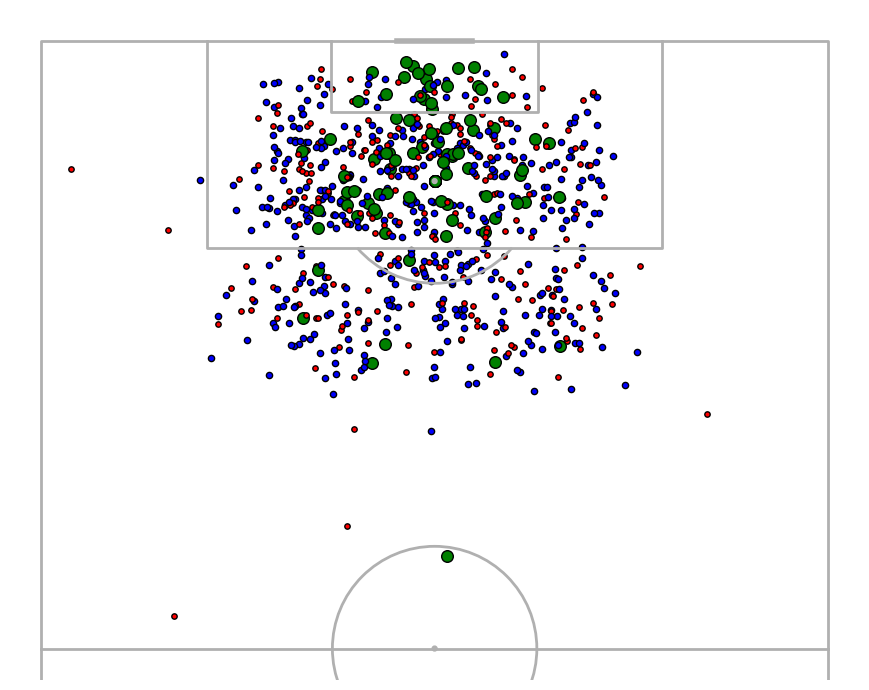

In [ ]:
from mplsoccer import VerticalPitch,Pitch
from matplotlib import pyplot as plt
pitch = VerticalPitch(pitch_type='opta', half=True, line_zorder=2)
fig, ax = pitch.draw(figsize=(12, 7))
for i, x in mu_shots.iterrows():
    goal = x['type_display_name']
    if goal == 'Goal':
        x_coord = x['x']
        y_coord = x['y']
        pitch.scatter(x_coord, y_coord, s=70, c = 'Green', ax=ax,edgecolors="black")
    elif goal=='SavedShot':
        x_coord = x['x']
        y_coord = x['y']
        pitch.scatter(x_coord, y_coord,s=20, c = 'blue', ax=ax, edgecolors='black')
    else:
        x_coord = x['x']
        y_coord = x['y']
        pitch.scatter(x_coord, y_coord,s=15, c = 'Red', ax=ax, edgecolors='black')

#ax.title('Shot')
plt.show()

In [ ]:
goalscorer = pd.DataFrame(shot_goal['player_name'].value_counts())
goalscorer.columns=['Goals']
goalscorer

,Goals
player_name,
Rasmus Højlund,16
Bruno Fernandes,15
Alejandro Garnacho,10
Scott McTominay,10
Marcus Rashford,8
Casemiro,5
Kobbie Mainoo,5
Harry Maguire,4
Antony,3
